In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from datetime import datetime
import joblib

expense_data = pd.read_csv("~/Downloads/Expense Sheet - Categorized.csv");
expense_data.rename(columns = {'head':'Head', 'category':'Category'}, inplace = True)

heads = ['date', 'Head', 'comment', 'amount', 'Category']
additional_train_datas = [
    [(datetime.now().strftime("%Y-%m-%dT%H:%M:%S"), 'diesel', '', 0.0, 'Fuel')],
    [(datetime.now().strftime("%Y-%m-%dT%H:%M:%S"), 'Ac fitting', '', 0.0, 'Appliances')],
    [(datetime.now().strftime("%Y-%m-%dT%H:%M:%S"), '2 ACs', '', 0.0, 'Appliances')],
    [(datetime.now().strftime("%Y-%m-%dT%H:%M:%S"), 'Air Condition', '', 0.0, 'Appliances')],
    [(datetime.now().strftime("%Y-%m-%dT%H:%M:%S"), 'Printout', '', 0.0, 'Education')],
    [(datetime.now().strftime("%Y-%m-%dT%H:%M:%S"), 'Coconut water', '', 0.0, 'Grocery')],
    [(datetime.now().strftime("%Y-%m-%dT%H:%M:%S"), 'paintor', '', 0.0, 'Maintenance')]
]
for additional_train_data in additional_train_datas:
    additional_train_data_df = pd.DataFrame.from_records(additional_train_data, columns=heads)
    expense_data = pd.concat([expense_data, additional_train_data_df], ignore_index=True)

    print(expense_data)
#expense_data.head


#X = expense_data.drop(columns=['date', 'amount', 'comment', 'Category']);
#y = expense_data['Category'];
#X.head



                     date           Head    comment  amount      Category
0     2019-06-18T18:47:30          T est        NaN     0.0         Other
1     2019-06-18T19:35:05     Vegetables        NaN   430.0       Grocery
2     2019-06-18T20:03:44  Bathla ladder        NaN  2199.0     Household
3     2019-06-18T20:05:52    Vegetables         NaN   405.0       Grocery
4     2019-06-18T20:06:09         Pizza         NaN   310.0  Food Outside
...                   ...            ...        ...     ...           ...
3899  2023-12-25T20:10:32          Lunch        NaN   600.0  Food Outside
3900  2023-12-26T21:00:05         Sweets        NaN  1628.0  Food Outside
3901  2023-12-26T21:12:57     Household   TDS meter   240.0     Household
3902  2023-12-26T21:22:41           Milk        NaN   100.0          Milk
3903  2023-12-28T19:30:55         diesel                0.0          Fuel

[3904 rows x 5 columns]
                     date           Head    comment  amount      Category
0     2019-06

In [2]:
expense_data['category_id'] = expense_data['Category'].factorize()[0]
category_id_expense = expense_data[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_expense.values)
id_to_category = dict(category_id_expense[['category_id', 'Category']].values)
expense_data

,date,Head,comment,amount,Category,category_id
0,2019-06-18T18:47:30,T est,NaN,0.0,Other,0
1,2019-06-18T19:35:05,Vegetables,NaN,430.0,Grocery,1
2,2019-06-18T20:03:44,Bathla ladder,NaN,2199.0,Household,2
3,2019-06-18T20:05:52,Vegetables,NaN,405.0,Grocery,1
4,2019-06-18T20:06:09,Pizza,NaN,310.0,Food Outside,3
...,...,...,...,...,...,...
3905,2023-12-28T19:30:55,2 ACs,,0.0,Appliances,15
3906,2023-12-28T19:30:55,Air Condition,,0.0,Appliances,15
3907,2023-12-28T19:30:55,Printout,,0.0,Education,7
3908,2023-12-28T19:30:55,Coconut water,,0.0,Grocery,1


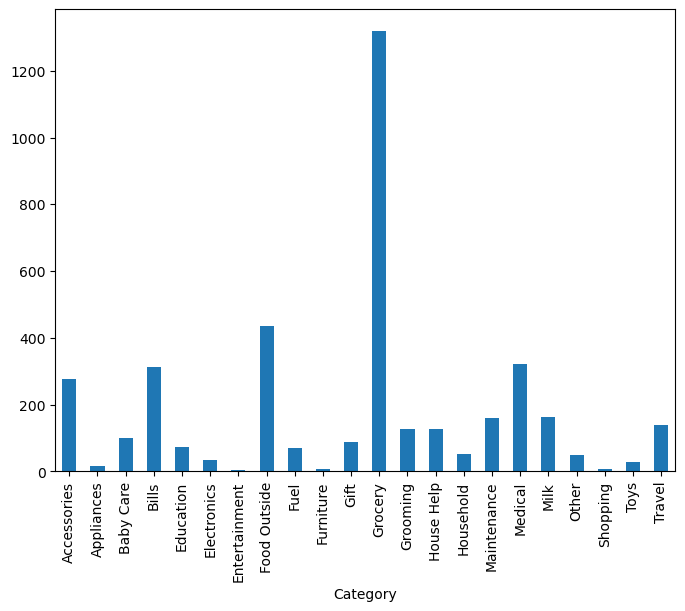

In [3]:
fig = plt.figure(figsize=(8,6))
expense_data.groupby('Category').Head.count().plot.bar(ylim=0)
plt.show()

In [4]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(expense_data.Head).toarray()
labels = expense_data.category_id
features.shape

(3910, 186)

In [5]:
N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Accessories':
  . Most correlated unigrams:
. accessories
. shopping
  . Most correlated bigrams:
. baby dress
. cuckoo dress
# 'Appliances':
  . Most correlated unigrams:
. machine
. washing
  . Most correlated bigrams:
. mobile recharge
. washing machine
# 'Baby Care':
  . Most correlated unigrams:
. diapers
. baby
  . Most correlated bigrams:
. baby wipes
. baby care
# 'Bills':
  . Most correlated unigrams:
. electricity
. mobile
  . Most correlated bigrams:
. netflix recharge
. mobile recharge
# 'Education':
  . Most correlated unigrams:
. book
. xerox
  . Most correlated bigrams:
. doctor consultation
. mobile recharge
# 'Electronics':
  . Most correlated unigrams:
. watch
. electronics
  . Most correlated bigrams:
. doctor consultation
. mobile recharge
# 'Entertainment':
  . Most correlated unigrams:
. vegetable
. groceries
  . Most correlated bigrams:
. doctor consultation
. mobile recharge
# 'Food Outside':
  . Most correlated unigrams:
. water
. snacks
  . Most correlated 

In [6]:
#expense_data['HeadAndCommentAndAmount'] = expense_data['Head'].astype(str) + '-' + expense_data['Comment'].astype(str)
X_train, X_test, y_train, y_test = train_test_split(
    expense_data['Head'], expense_data['Category'], test_size=.001, random_state = 0
)

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = LogisticRegression(fit_intercept=False).fit(X_train_tfidf, y_train)
#clf = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0).fit(X_train_tfidf, y_train)
#clf = MultinomialNB().fit(X_train_tfidf, y_train)
#clf = LinearSVC().fit(X_train_tfidf, y_train)

y_predicted = clf.predict(X_train_tfidf)
print(metrics.classification_report(y_train, y_predicted))

               precision    recall  f1-score   support

  Accessories       1.00      1.00      1.00       276
   Appliances       0.94      0.94      0.94        17
    Baby Care       0.98      0.98      0.98       100
        Bills       0.99      1.00      1.00       309
    Education       0.99      1.00      0.99        73
  Electronics       0.94      0.94      0.94        34
Entertainment       1.00      1.00      1.00         4
 Food Outside       1.00      1.00      1.00       437
         Fuel       1.00      1.00      1.00        70
    Furniture       0.75      1.00      0.86         6
         Gift       0.98      1.00      0.99        89
      Grocery       1.00      0.99      1.00      1318
     Grooming       0.98      0.99      0.99       128
   House Help       1.00      0.99      1.00       126
    Household       0.92      0.90      0.91        52
  Maintenance       0.98      0.99      0.99       159
      Medical       1.00      1.00      1.00       321
         

In [7]:
results = clf.predict(count_vect.transform(["Laptop"]))
#prob_per_class_dictionary = dict(zip(model.classes_, results))

print(results)

['Electronics']


In [8]:
joblib.dump(clf, '/Users/aloksingh/git/expense-catecorization/expense-categorization-mdl.joblib');

In [9]:
joblib.dump(count_vect, '/Users/aloksingh/git/expense-catecorization/expense-categorization-vct.joblib');

In [10]:
clf_LSVC = LinearSVC().fit(X_train_tfidf, y_train)

y_predicted = clf_LSVC.predict(X_train_tfidf)
print(metrics.classification_report(y_train, y_predicted))

               precision    recall  f1-score   support

  Accessories       1.00      1.00      1.00       276
   Appliances       0.94      1.00      0.97        17
    Baby Care       0.99      0.99      0.99       100
        Bills       1.00      1.00      1.00       309
    Education       0.99      1.00      0.99        73
  Electronics       1.00      1.00      1.00        34
Entertainment       1.00      1.00      1.00         4
 Food Outside       1.00      1.00      1.00       437
         Fuel       1.00      1.00      1.00        70
    Furniture       1.00      1.00      1.00         6
         Gift       0.99      1.00      0.99        89
      Grocery       1.00      1.00      1.00      1318
     Grooming       0.99      1.00      1.00       128
   House Help       1.00      1.00      1.00       126
    Household       0.98      0.98      0.98        52
  Maintenance       1.00      1.00      1.00       159
      Medical       1.00      1.00      1.00       321
         

/Users/aloksingh/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [25]:
results = clf_LSVC.predict(count_vect.transform(["shirt"]))

print(results)

['Accessories']


In [12]:
joblib.dump(clf_LSVC, '/Users/aloksingh/git/expense-catecorization/expense-categorization-LSVC-mdl.joblib');

In [13]:
clf_MNB = MultinomialNB().fit(X_train_tfidf, y_train)

y_predicted = clf_MNB.predict(X_train_tfidf)
print(metrics.classification_report(y_train, y_predicted))

               precision    recall  f1-score   support

  Accessories       0.98      0.95      0.96       276
   Appliances       0.00      0.00      0.00        17
    Baby Care       0.97      0.77      0.86       100
        Bills       0.97      1.00      0.99       309
    Education       1.00      0.56      0.72        73
  Electronics       1.00      0.03      0.06        34
Entertainment       0.00      0.00      0.00         4
 Food Outside       0.97      1.00      0.98       437
         Fuel       1.00      0.93      0.96        70
    Furniture       0.00      0.00      0.00         6
         Gift       1.00      0.85      0.92        89
      Grocery       0.82      1.00      0.90      1318
     Grooming       1.00      0.84      0.92       128
   House Help       1.00      0.94      0.97       126
    Household       0.00      0.00      0.00        52
  Maintenance       1.00      0.89      0.94       159
      Medical       0.99      0.99      0.99       321
         

/Users/aloksingh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aloksingh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aloksingh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
clf_RFC = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0).fit(X_train_tfidf, y_train)

y_predicted = clf_RFC.predict(X_train_tfidf)
print(metrics.classification_report(y_train, y_predicted))

               precision    recall  f1-score   support

  Accessories       0.00      0.00      0.00       276
   Appliances       0.00      0.00      0.00        17
    Baby Care       0.00      0.00      0.00       100
        Bills       1.00      0.00      0.01       309
    Education       0.00      0.00      0.00        73
  Electronics       0.00      0.00      0.00        34
Entertainment       0.00      0.00      0.00         4
 Food Outside       0.00      0.00      0.00       437
         Fuel       0.00      0.00      0.00        70
    Furniture       0.00      0.00      0.00         6
         Gift       0.00      0.00      0.00        89
      Grocery       0.34      1.00      0.50      1318
     Grooming       0.00      0.00      0.00       128
   House Help       0.00      0.00      0.00       126
    Household       0.00      0.00      0.00        52
  Maintenance       0.00      0.00      0.00       159
      Medical       0.00      0.00      0.00       321
         

/Users/aloksingh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aloksingh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aloksingh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/Users/aloksingh/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/aloksingh/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/aloksingh/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/aloksingh/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/aloksingh/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: Future

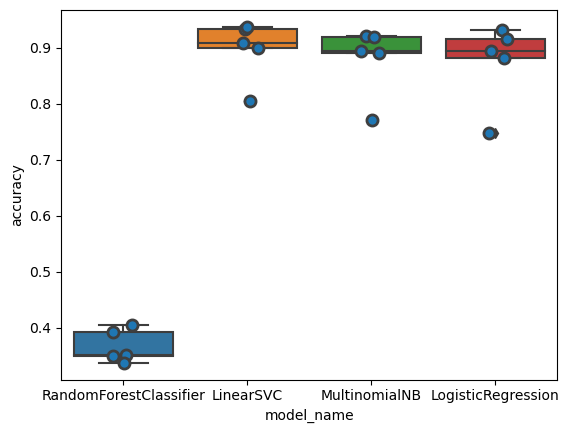

In [15]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(fit_intercept=False),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [16]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.896675
LogisticRegression        0.874425
MultinomialNB             0.879028
RandomForestClassifier    0.367263
Name: accuracy, dtype: float64

/Users/aloksingh/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


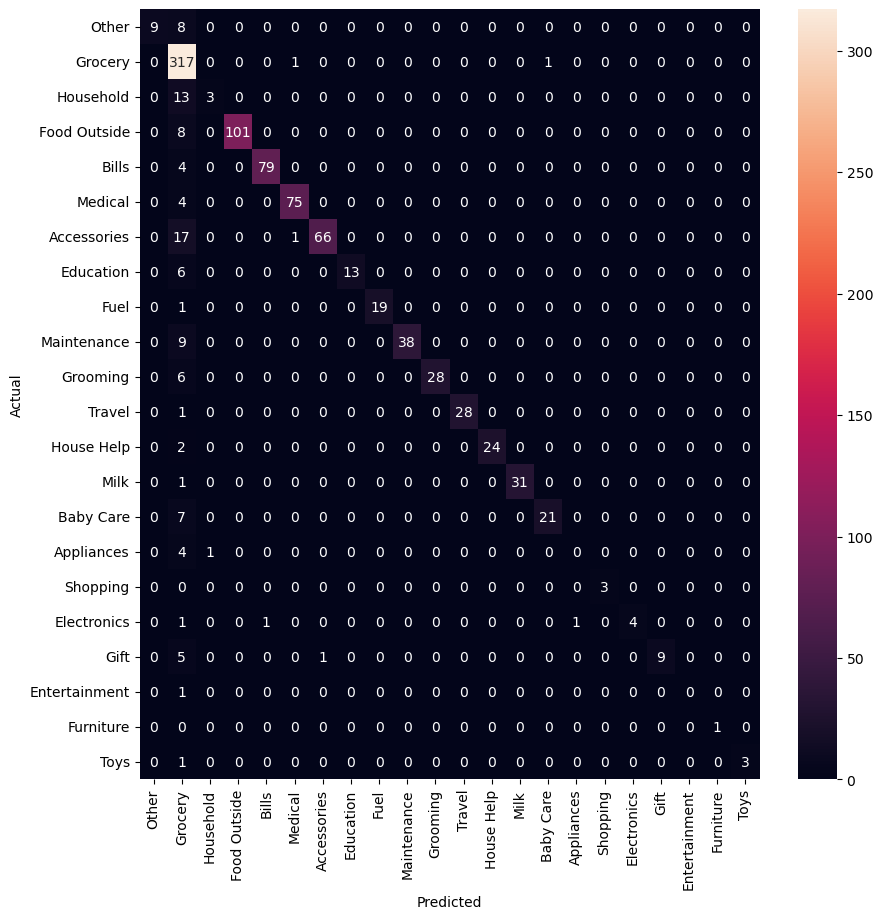

/tmp/ipykernel_32671/457972903.py:18: NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/
  run = neptune.init_run(


https://app.neptune.ai/home-stack/ExpenseCategorization/e/EXCAT-1
This classifier does not provide predictions probabilities. Error: 'LinearSVC' object has no attribute 'predict_proba'


/Users/aloksingh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aloksingh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Did not log Precision-Recall chart: this classifier does not provide predictions probabilities.Error 'LinearSVC' object has no attribute 'predict_proba'
Shutting down background jobs, please wait a moment...


/tmp/ipykernel_32671/457972903.py:27: NeptuneUnsupportedType: You're attempting to log a type that is not directly supported by Neptune (<class 'NoneType'>).
        Convert the value to a supported type, such as a string or float, or use stringify_unsupported(obj)
        for dictionaries or collections that contain unsupported values.
        For more, see https://docs.neptune.ai/help/value_of_unsupported_type
  run["classifier"] = npt_utils.create_classifier_summary(


Done!
Waiting for the remaining 107 operations to synchronize with Neptune. Do not kill this process.
All 107 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/home-stack/ExpenseCategorization/e/EXCAT-1/metadata


In [30]:
#model = LogisticRegression(fit_intercept=False)
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, expense_data.index, test_size=0.25, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_expense.Category.values, yticklabels=category_id_expense.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [ ]:
import neptune
import neptune.integrations.sklearn as npt_utils

run = neptune.init_run(
    project="home-stack/ExpenseCategorization",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIwNTYyODcyOC1kZDMxLTQyMWUtOWM1NS04MmM0NDQ1NmNjYjkifQ==",
)  # your credentials

# Neptune integration with scikit-learn works with
# the regression and classification problems as well.
# Check the user guide in the documentation for more details:
# https://docs.neptune.ai/integrations/sklearn
run["classifier"] = npt_utils.create_classifier_summary(
    model, X_train, X_test, y_train, y_test
)

run.stop()

In [18]:
#pd.options.display.float_format = '{:,.2f}'.format
#test_data = pd.read_csv("~/Downloads/Expense Sheet - Categorized.csv").drop(columns=['Timestamp', 'Amount', 'Month', 'Year', 'Category', 'Comment']);
test_data = pd.read_csv("~/Downloads/Expense Sheet - Categorized.csv")
test_data.head()
print()

#expense_data['category_id'] = expense_data['Category'].factorize()[0]
#clf.predict(count_vect.transform(list(test_data)))
#test_data['predicted'] = clf.predict(test_data['Head'].factorize()[0])

#test_data.groupby(['predicted']).sum()
#test_data.groupby(['predicted']).sum().plot.pie( subplots=True,figsize=(5, 5))

In [19]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
corpus = ['this is the first document',
          'this document is the second document',
          'and this is the third one',
          'is this the first document']
vocabulary = ['this', 'document', 'first', 'is', 'second', 'the',
              'and', 'one']
pipe = Pipeline([('count', CountVectorizer(vocabulary=vocabulary)),
                 ('tfid', TfidfTransformer())]).fit(corpus)
pipe['count'].transform(corpus).toarray()


array([[1, 1, 1, 1, 0, 1, 0, 0],
       [1, 2, 0, 1, 1, 1, 0, 0],
       [1, 0, 0, 1, 0, 1, 1, 1],
       [1, 1, 1, 1, 0, 1, 0, 0]])

In [20]:
pipe['tfid'].idf_
pipe.transform(corpus).shape

(4, 8)